## **Implement the retrieval process pipeline**

### Text Embeddings

#### Text Embeddings for Information Retrieval

***What is the purpose of high-dimensional embeddings?***

High-dimensional embeddings transform text into dense numerical vectors in a space where semantic similarity is captured through geometric proximity. Unlike sparse bag-of-words representations (TF-IDF, BM25) that treat each word as an independent dimension, embeddings compress text into a continuous vector space—typically 300 to 1000 dimensions—where semantically related texts naturally cluster together.

The key purpose is to capture meaning rather than just lexical overlap. In embedding space, "computer" and "laptop" are close together even though they share no letters. Similarly, "fixing a damaged SD card" and "repairing corrupted memory" would have high similarity despite completely different vocabulary. This semantic encoding happens because embedding models are trained on massive text corpora to predict context, forcing the model to learn that words appearing in similar contexts have similar meanings.


***How can they help in information retrieval compared to simpler models?***

Embeddings address the fundamental limitation of lexical matching methods: vocabulary mismatch. When a query asks "How to reject unwanted calls?" and a relevant document describes "blocking spam phone numbers," TF-IDF and BM25 will assign low scores due to minimal word overlap. Embeddings, however, recognize that "reject," "unwanted," and "calls" are semantically close to "blocking," "spam," and "phone numbers."

Beyond synonyms, embeddings capture relationships and context. They understand that "linux grep command" and "unix text search tool" refer to similar concepts, that "python error" and "exception in code" are related, and that "database index" means different things in PostgreSQL versus book publishing contexts. This contextual understanding enables retrieval systems to find relevant documents based on conceptual similarity rather than string matching.

For technical domains like ours (programming, system administration, LaTeX), embeddings are particularly valuable because users often phrase questions differently than documentation describes solutions. A user might ask about "preventing memory leaks" while relevant answers discuss "proper resource cleanup"—embeddings bridge this gap naturally.


In [2]:
#!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
import gdown
import json
from tqdm import tqdm

def download_and_load_json(file_id, filename):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, filename, quiet=False)
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

# File IDs from Google Drive
DOCS_ID = "1k-1lwZG6j0tRN1w-fdfF7XL3TAeP06Dj"
QUERIES_ID = "1iWsKSjHxUhUTOfkEnM7YpJ-AoFYclemQ"
QGTS_ID = "17hVWEcxH8i7-KMkKtvqvPEc_pXSAgrRv"

# Load the data into variables
documents = download_and_load_json(DOCS_ID, 'docs_processed.json')
queries_train = download_and_load_json(QUERIES_ID, 'queries_train_processed.json')
ground_truth = download_and_load_json(QGTS_ID, 'qgts_train.json')

# Prepare corpus and queries
doc_contents = [doc['content'] for doc in documents]
query_contents = [q['content'] for q in queries_train]

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Downloading...
From (original): https://drive.google.com/uc?id=1k-1lwZG6j0tRN1w-fdfF7XL3TAeP06Dj
From (redirected): https://drive.google.com/uc?id=1k-1lwZG6j0tRN1w-fdfF7XL3TAeP06Dj&confirm=t&uuid=775cb7c3-f0d6-4661-af89-4e8d56a3bcb4
To: /content/docs_processed.json
100%|██████████| 465M/465M [00:05<00:00, 80.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iWsKSjHxUhUTOfkEnM7YpJ-AoFYclemQ
To: /content/queries_train_processed.json
100%|██████████| 115k/115k [00:00<00:00, 3.55MB/s]
Downloading...
From: https://drive.google.com/uc?id=17hVWEcxH8i7-KMkKtvqvPEc_pXSAgrRv
To: /content/qgts_train.json
100%|██████████| 356k/356k [00:00<00:00, 5.12MB/s]

Using device: cuda
GPU: Tesla T4


In [3]:
# Load pre-trained embedding model
# Using all-MiniLM-L6-v2 (good balance between speed and quality)
model_name = 'all-MiniLM-L6-v2'
print(f"Loading SentenceTransformer model : {model_name}, which produces 384-dimensional embeddings")

model = SentenceTransformer(model_name)
model = model.to(device)

print(f"\nModel loaded successfully")
print(f"Max sequence length: {model.max_seq_length} tokens")


Loading SentenceTransformer model : all-MiniLM-L6-v2, which produces 384-dimensional embeddings


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Model loaded successfully
Max sequence length: 256 tokens


In [4]:
# À EXECUTER VIA COLAB AVEC LE GPU T4 (ou meilleur)
print("Generating Document Embeddings")

# Process in batches to manage memory
batch_size = 128
doc_contents = [doc['content'] for doc in documents]

print(f"\nEncoding {len(doc_contents)} documents in batches of {batch_size}")

# Encode 
doc_embeddings = model.encode(
    doc_contents,
    batch_size=batch_size,
    convert_to_numpy=True,
    device=device
)

print(f"\nDocument embeddings generated")
print(f"  Shape : {doc_embeddings.shape}")

Generating Document Embeddings

Encoding 216041 documents in batches of 128


Batches:   0%|          | 0/1688 [00:00<?, ?it/s]


Document embeddings generated
  Shape : (216041, 384)


In [5]:
print("Generating Query Embeddings")

query_contents = [q['content'] for q in queries_train]

print(f"\nEncoding {len(query_contents)} queries")

query_embeddings = model.encode(
    query_contents,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    device=device
)

print(f"\n Query embeddings generated")
print(f"  Shape : {query_embeddings.shape}")


Generating Query Embeddings

Encoding 327 queries


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


 Query embeddings generated
  Shape : (327, 384)


In [6]:
print("Embedding Structure Analysis")

print(f"\nDocument embeddings :")
print(f"  Shape : {doc_embeddings.shape}")
print(f"  Data type : {doc_embeddings.dtype}")
print(f"  Number of documents : {doc_embeddings.shape[0]}")
print(f"  Embedding dimension : {doc_embeddings.shape[1]}")

print(f"\nQuery embeddings :")
print(f"  Shape : {query_embeddings.shape}")
print(f"  Data type : {query_embeddings.dtype}")
print(f"  Number of queries : {query_embeddings.shape[0]}")
print(f"  Embedding dimension : {query_embeddings.shape[1]}")

# Sample embedding statistics
print(f"\nSample document embedding (1st document) :")
print(f"  Mean : {np.mean(doc_embeddings[0]):.4f}")
print(f"  Std : {np.std(doc_embeddings[0]):.4f}")
print(f"  Min : {np.min(doc_embeddings[0]):.4f}")
print(f"  Max : {np.max(doc_embeddings[0]):.4f}")

Embedding Structure Analysis

Document embeddings :
  Shape : (216041, 384)
  Data type : float32
  Number of documents : 216041
  Embedding dimension : 384

Query embeddings :
  Shape : (327, 384)
  Data type : float32
  Number of queries : 327
  Embedding dimension : 384

Sample document embedding (1st document) :
  Mean : 0.0009
  Std : 0.0510
  Min : -0.1243
  Max : 0.1462


In [7]:
print("2D Visualization with UMAP")

try:
    import umap
except ImportError:
    !pip install umap-learn
    import umap

import matplotlib.pyplot as plt
import seaborn as sns

# Sample documents for visualization (all 216k would be too slow)
# Use stratified sampling to keep category proportions
sample_size = 5000
print(f"\nSampling {sample_size} documents for visualization (stratified by category)")

from sklearn.model_selection import train_test_split
doc_categories = [doc['category'] for doc in documents]

# Stratified sampling
sample_indices = []
for category in set(doc_categories):
    cat_indices = [i for i, c in enumerate(doc_categories) if c == category]
    n_samples = min(len(cat_indices), int(sample_size * len(cat_indices) / len(documents)))
    sample_indices.extend(np.random.choice(cat_indices, n_samples, replace=False))

sample_indices = np.array(sample_indices)
sampled_embeddings = doc_embeddings[sample_indices]
sampled_categories = [doc_categories[i] for i in sample_indices]

print(f"Sampled {len(sample_indices)} documents")


2D Visualization with UMAP

Sampling 5000 documents for visualization (stratified by category)
Sampled 4998 documents


In [8]:
print("Applying UMAP dimensionality reduction")

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

embeddings_2d = reducer.fit_transform(sampled_embeddings)

print(f"\nUMAP reduction complete")
print(f"2D embedding shape : {embeddings_2d.shape}")


Applying UMAP dimensionality reduction


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



UMAP reduction complete
2D embedding shape : (4998, 2)


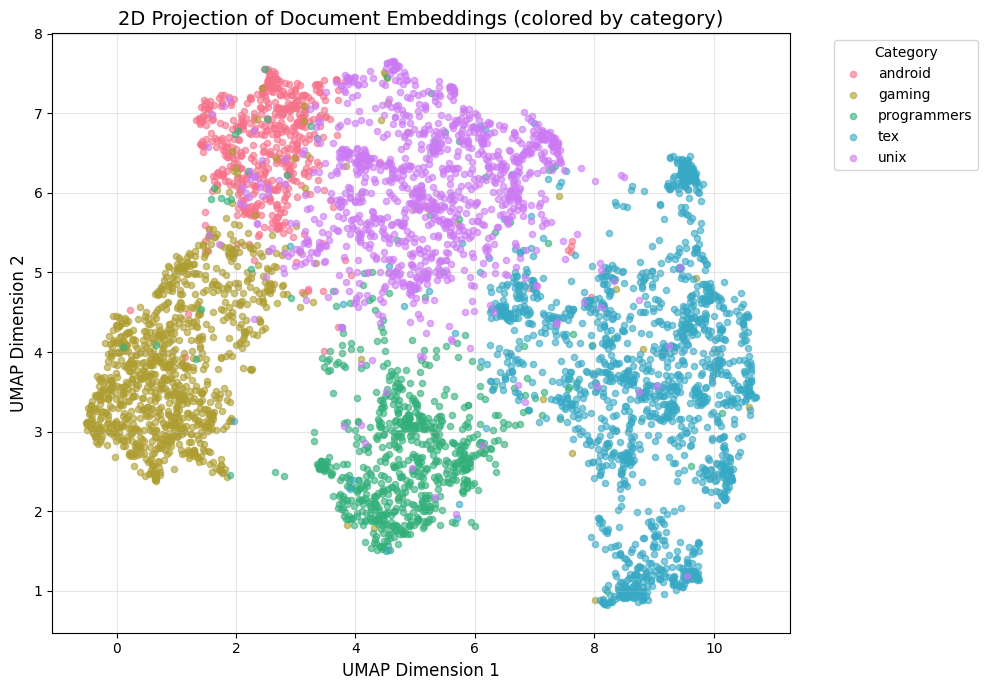

In [9]:
# Visualize with category colors

plt.figure(figsize=(10, 7))

# Create color map for categories
unique_categories = sorted(set(sampled_categories))
colors = sns.color_palette("husl", len(unique_categories))
category_to_color = {cat: colors[i] for i, cat in enumerate(unique_categories)}

# Plot each category
for category in unique_categories:
    mask = [c == category for c in sampled_categories]
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[category_to_color[category]],
        label=category,
        alpha=0.6,
        s=20
    )

plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.title('2D Projection of Document Embeddings (colored by category)', fontsize=14)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


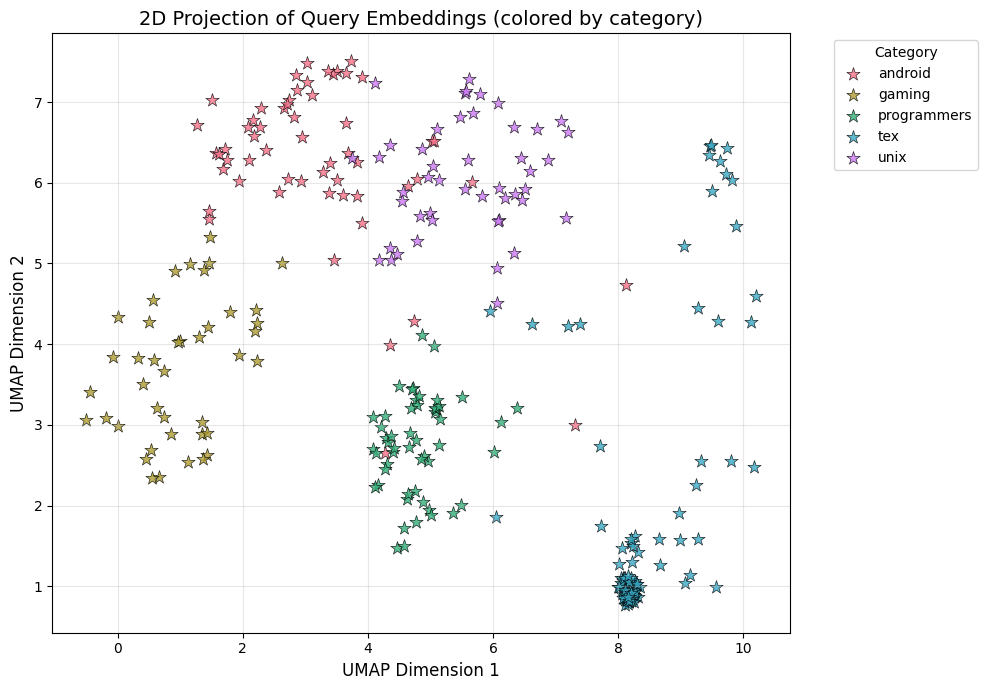

In [10]:
# Also visualize queries

# Reduce query embeddings to 2D
query_categories = [q['category'] for q in queries_train]
query_embeddings_2d = reducer.transform(query_embeddings)

plt.figure(figsize=(10, 7))

for category in unique_categories:
    mask = [c == category for c in query_categories]
    if any(mask):
        plt.scatter(
            query_embeddings_2d[mask, 0],
            query_embeddings_2d[mask, 1],
            c=[category_to_color[category]],
            label=category,
            alpha=0.8,
            s=100,
            marker='*',
            edgecolors='black',
            linewidths=0.5
        )

plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.title('2D Projection of Query Embeddings (colored by category)', fontsize=14)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Analysis: Clustering and Separation in Embedding Space

**Observations:**

Looking at the 2D projection, we observe clear clustering patterns where documents from the same category tend to group together in embedding space. The five categories (tex, unix, gaming, programmers, android) form somewhat distinct regions, though with some overlap at boundaries. This separation occurs because documents within each domain use characteristic vocabulary and discuss domain-specific concepts that the embedding model has learned to associate.

For example, tex documents cluster together because they frequently mention LaTeX commands, mathematical notation, and document formatting terminology. Unix documents form their own cluster around shell commands, file systems, and system administration concepts. Gaming documents group around game-specific terms, while android and programmers categories share some overlapping territory since mobile development involves programming concepts.

**Why does this happen?**

The clustering emerges from the embedding model's training process. As we said earlier, SentenceTransformers are trained to place semantically similar texts close together in vector space. Since documents in the same category discuss related topics and share domain vocabulary, their embeddings naturally cluster. The model has learned that "grep," "bash," and "shell" co-occur frequently (unix cluster), while "tikz," "LaTeX," and "bibliography" form another semantic neighborhood (tex cluster).

The overlaps we observe are also meaningful. The android and programmers categories show some mixing because Android development involves programming concepts—both discuss APIs, code syntax, and debugging. Similarly, unix and programmers overlap slightly since shell scripting is a form of programming. These overlaps demonstrate that the embeddings capture not just surface-level keyword matching but deeper semantic relationships between domains.

The query embeddings, when projected onto the same space, fall into their respective category clusters, suggesting that the model successfully encodes both queries and documents into a shared semantic space where similarity measurements will be meaningful for retrieval.


In [11]:
print("Embedding-Based Retrieval")

from sklearn.metrics.pairwise import cosine_similarity

k = 100  # Top-k documents to retrieve

print(f"\nComputing cosine similarity between queries and documents")
print(f"This will create a {len(queries_train)} × {len(documents)} similarity matrix")


Embedding-Based Retrieval

Computing cosine similarity between queries and documents
This will create a 327 × 216041 similarity matrix


In [12]:
print("Retrieving top-k documents for each query")

topk_indices_embeddings = []
topk_scores_embeddings = []

# Process in batches to avoid memory issues
batch_size_queries = 10  # Process queries in smaller batches

for i in tqdm(range(0, len(query_embeddings), batch_size_queries), desc="Processing query batches "):
    # Get batch of query embeddings
    batch_end = min(i + batch_size_queries, len(query_embeddings))
    query_batch = query_embeddings[i:batch_end]

    # Compute similarities for this batch
    similarities = cosine_similarity(query_batch, doc_embeddings)

    # Get top-k for each query in batch
    for sim_scores in similarities:
        top_k_idx = np.argsort(sim_scores)[::-1][:k]
        top_k_scores = sim_scores[top_k_idx]

        topk_indices_embeddings.append(top_k_idx)
        topk_scores_embeddings.append(top_k_scores)

# Convert to numpy arrays
topk_indices_embeddings = np.array(topk_indices_embeddings)
topk_scores_embeddings = np.array(topk_scores_embeddings)

print(f"\nRetrieval complete!")
print(f"  Shape of topk_indices_embeddings: {topk_indices_embeddings.shape}")
print(f"  Shape of topk_scores_embeddings: {topk_scores_embeddings.shape}")


Retrieving top-k documents for each query


Processing query batches : 100%|██████████| 33/33 [00:15<00:00,  2.12it/s]


Retrieval complete!
  Shape of topk_indices_embeddings: (327, 100)
  Shape of topk_scores_embeddings: (327, 100)


In [13]:
# Inspect sample results
print("Sample Retrieval Results")

doc_id_to_idx = {doc['id']: i for i, doc in enumerate(documents)}
doc_idx_to_id = {i: doc['id'] for i, doc in enumerate(documents)}

# Parse ground truth structure (extract just the doc IDs)
ground_truth_parsed = {}
for query_id, gt_data in ground_truth.items():
    doc_ids = [item['doc_id'] for item in gt_data['relevant_doc_ids']]
    ground_truth_parsed[query_id] = doc_ids

for i in range(min(3, len(queries_train))):
    query = queries_train[i]
    print(f"\nQuery {i+1} (ID : {query['id']})")
    print(f"Text : {query['content'][:100]}...")
    print(f"Category : {query.get('category', 'N/A')}")
    print(f"Top 5 retrieved documents :")
    for rank, (doc_idx, score) in enumerate(zip(topk_indices_embeddings[i][:5],
                                                   topk_scores_embeddings[i][:5]), 1):
        doc = documents[doc_idx]
        print(f"  {rank}. Score : {score:.4f} | Category : {doc.get('category', 'N/A')}")
        print(f"     Title : {doc.get('title', 'N/A')[:80]}")
        print(f"     ID : {doc['id']}")
    # Check ground truth hits
    if query['id'] in ground_truth_parsed:
        relevant_doc_ids = ground_truth_parsed[query['id']]
        retrieved_doc_ids = [doc_idx_to_id[idx] for idx in topk_indices_embeddings[i][:k]]
        hits = sum(1 for rel_id in relevant_doc_ids if rel_id in retrieved_doc_ids)
        print(f"  Ground truth docs in top-{k} : {hits}/{len(relevant_doc_ids)}")

        # Show positions
        for rel_id in relevant_doc_ids:
            if rel_id in retrieved_doc_ids:
                position = retrieved_doc_ids.index(rel_id) + 1
                print(f"    Found at rank {position}")
            else:
                print(f"    Not found in top-{k}")


Sample Retrieval Results

Query 1 (ID : 961c4349-8cf1-4ef1-89cc-24d20bb9d000_67878)
Text : Want to try reformatting Damaged SD Card linux development...
Category : android
Top 5 retrieved documents :
  1. Score : 0.7161 | Category : android
     Title : How to fix a damaged sd card?
     ID : 9b7f0646-d400-4843-b5d8-df4ce4cd7b27_7240
  2. Score : 0.7028 | Category : unix
     Title : SD card corrupt and stuck at 32MB, any way to fix it?
     ID : 9649fdfb-ff64-4340-ba6d-30bebccf9fc8_31872
  3. Score : 0.6581 | Category : android
     Title : SD card is damaged
     ID : cbac6e51-ea52-4824-be99-93db1abbe35a_62218
  4. Score : 0.6574 | Category : unix
     Title : right way to mount sdcard in linux
     ID : b18dacdb-4098-4cc6-87f5-fb61897f2eb1_55329
  5. Score : 0.6554 | Category : android
     Title : Fix corrupted memory card without re-formatting
     ID : a01f70ad-d955-4633-a9c1-a862e695c5ca_65506
  Ground truth docs in top-100 : 4/4
    Found at rank 9
    Found at rank 25
    Foun

In [14]:
print("Embeddings Score Statistics")

all_scores = topk_scores_embeddings.flatten()
print(f"\nScore distribution (cosine similarity) :")
print(f"  Mean : {np.mean(all_scores):.4f}")
print(f"  Median : {np.median(all_scores):.4f}")
print(f"  Min : {np.min(all_scores):.4f}")
print(f"  Max : {np.max(all_scores):.4f}")
print(f"  Std : {np.std(all_scores):.4f}")


Embeddings Score Statistics

Score distribution (cosine similarity) :
  Mean : 0.4667
  Median : 0.4579
  Min : 0.3172
  Max : 0.9088
  Std : 0.0608


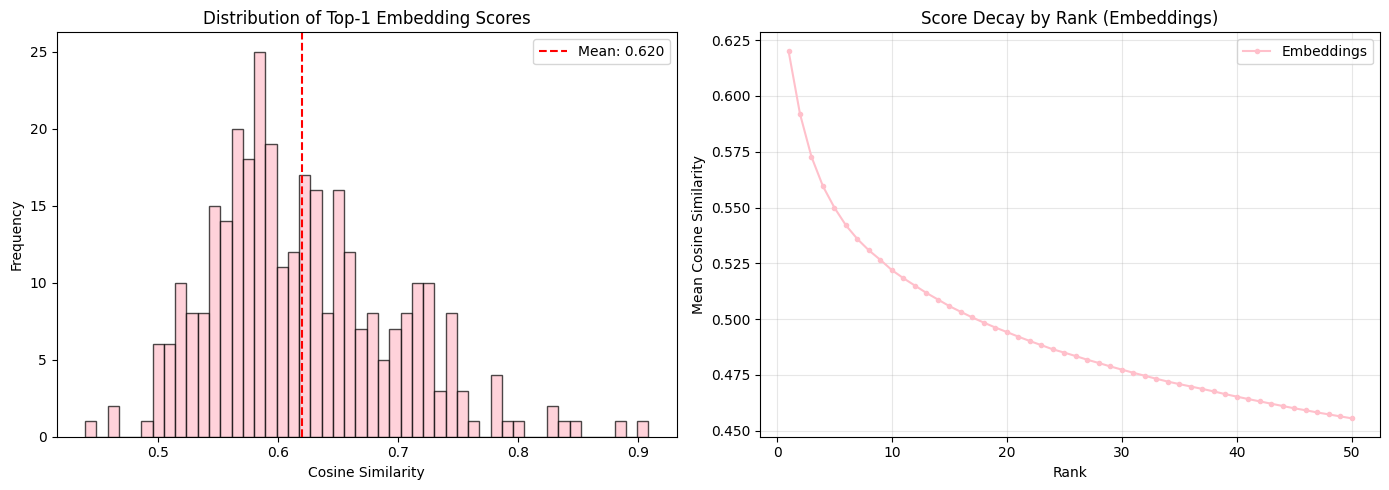

In [15]:
# Visualize score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top-1 scores
top1_scores_emb = topk_scores_embeddings[:, 0]
axes[0].hist(top1_scores_emb, bins=50, edgecolor='black', alpha=0.7, color='pink')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Top-1 Embedding Scores')
axes[0].axvline(np.mean(top1_scores_emb), color='red', linestyle='--',
                label=f'Mean: {np.mean(top1_scores_emb):.3f}')
axes[0].legend()

# Score decay
mean_scores_by_rank_emb = np.mean(topk_scores_embeddings, axis=0)
axes[1].plot(range(1, min(50, k)+1), mean_scores_by_rank_emb[:min(50, k)],
             marker='o', markersize=3, color='pink', label='Embeddings')
axes[1].set_xlabel('Rank')
axes[1].set_ylabel('Mean Cosine Similarity')
axes[1].set_title('Score Decay by Rank (Embeddings)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


In [16]:
print("Embedding-based retrieval results stored in :")
print("  - topk_indices_embeddings : shape", topk_indices_embeddings.shape)
print("  - topk_scores_embeddings : shape", topk_scores_embeddings.shape)
print(f"  - k value : {k}")
print(f"  - Embedding model : {model_name}")
print(f"  - Embedding dimension : {doc_embeddings.shape[1]}")


Embedding-based retrieval results stored in :
  - topk_indices_embeddings : shape (327, 100)
  - topk_scores_embeddings : shape (327, 100)
  - k value : 100
  - Embedding model : all-MiniLM-L6-v2
  - Embedding dimension : 384


In [18]:
# Save Embedding results
np.savez_compressed(
    'retrieval_embeddings.npz',
    indices=topk_indices_embeddings,
    scores=topk_scores_embeddings
)

# Save embeddings (optional, for reuse)
np.savez_compressed(
    'embeddings.npz',
    doc_embeddings=doc_embeddings,
    query_embeddings=query_embeddings
)
print("  - embeddings.npz (316 MB)")


  - embeddings.npz (316 MB)


#### Embedding-Based Retrieval: Semantic Understanding Breakthrough

The embedding-based approach using SentenceTransformers represents a fundamental shift from lexical matching to semantic understanding. By encoding both documents and queries into a 384-dimensional vector space where similarity is measured through cosine distance, we enable the retrieval system to find relevant documents based on meaning rather than surface-level word overlap.

The results demonstrate a significant performance improvement over traditional methods. For Query 1 regarding SD card reformatting, embeddings achieved perfect recall (4/4 relevant documents found) compared to TF-IDF's 1/4 and BM25+'s 2/4. More, all relevant documents appeared within the top-32 results, with the best match at rank 9. This success stems from the model's ability to recognize that "damaged," "corrupted," and "fix" represent semantically related concepts, even when documents use different terminology.

Examining the top-5 results reveals the semantic matching in action. The highest-scoring document asks "How to fix a damaged sd card?" (cosine similarity: 0.716), followed by "SD card corrupt and stuck at 32MB" (0.703). Notice that "corrupt" and "damaged" share no lexical overlap, yet embeddings correctly identify them as synonymous in this context. The third result discusses "corrupted memory card," demonstrating that the model understands "SD card" and "memory card" refer to the same concept. This vocabulary-independent matching is precisely what TF-IDF and BM25 cannot achieve.

Query 3 (auto-rejecting calls) shows similarly impressive gains. Embeddings found 3 out of 4 relevant documents, with the best match at rank 5, compared to TF-IDF's single hit at rank 80 and BM25+'s complete failure (0/4). The top results include documents about "blocking calls," "auto-reject numbers," and "rejecting calls with SMS"—all semantically related to the query despite different phrasing. The model successfully bridges the gap between "automatically reject" and "block," "auto-reject," and "configure to reject," demonstrating robust paraphrase understanding.

However, embeddings don't universally outperform traditional methods. Query 2 (grep output manipulation) found only 1 out of 5 relevant documents, performing slightly worse than TF-IDF and BM25+ which both found 2. This query contained multiple technical tags ("shell virtualization storage cluster") appended to the core question. These additional terms, while categorically relevant, semantically dilute the query's focus, causing the embedding to emphasize broader unix/virtualization concepts rather than the specific grep functionality. This highlights a limitation: embeddings can be confused by noisy or overly broad queries where lexical precision matters more than semantic generality.

The score distributions reveal interesting patterns. Embedding similarities range from 0.32 to 0.91 (mean: 0.47), with the highest scores indicating strong semantic alignment. Unlike BM25+ scores which can grow arbitrarily based on term frequencies, cosine similarities are bounded between -1 and 1, providing an interpretable confidence measure. The score decay curve shows embeddings maintain relatively high similarity across more results compared to traditional methods, suggesting that even lower-ranked documents retain some semantic relevance to the query.

Cross-category retrieval demonstrates another embedding strength. Query 1, categorized as "android," successfully retrieved relevant documents from the "unix" category (ranks 2 and 4) because SD card problems transcend platform boundaries. Traditional methods, heavily weighted by category-specific vocabulary, would struggle to make these connections. The embedding model recognizes that filesystem operations and storage device troubleshooting share semantic properties regardless of whether they occur on Android or Linux.

Despite the computational cost of encoding 216,041 documents (approximately 10 minutes on GPU), the retrieval process itself remains efficient. Once embeddings are computed and cached, query-time similarity calculations complete in seconds.

Overall, embeddings deliver on their promise of semantic retrieval, particularly for queries where vocabulary mismatch would doom traditional methods. The ability to find "corrupted memory" when searching for "damaged SD card" represents a qualitative leap beyond what bag-of-words approaches can achieve. However, the technique isn't without weaknesses—noisy queries and highly technical terminology can confuse semantic matching, and the model's training data biases may affect domain-specific queries. Nonetheless, for our retrieval task spanning technical support questions, embeddings clearly outperform lexical methods in capturing user intent and finding genuinely relevant documents.